# Convolutional Neural Networks


Photo sharing and photo storage services like to have location data for each photo that is uploaded. With the location data, these services can build advanced features, such as automatic suggestion of relevant tags or automatic photo organization, which help provide a compelling user experience. Although a photo's location can often be obtained by looking at the photo's metadata, many photos uploaded to these services will not have location metadata available. This can happen when, for example, the camera capturing the picture does not have GPS or if a photo's metadata is scrubbed due to privacy concerns.

If no location metadata for an image is available, one way to infer the location is to detect and classify a discernable landmark in the image. Given the large number of landmarks across the world and the immense volume of images that are uploaded to photo sharing services, using human judgement to classify these landmarks would not be feasible.

In this notebook, you will take the first steps towards addressing this problem by building models to automatically predict the location of the image based on any landmarks depicted in the image. At the end of this project, your code will accept any user-supplied image as input and suggest the top k most relevant landmarks from 50 possible landmarks from across the world. The image below displays a potential sample output of your finished project.

![Sample landmark classification output](images/sample_landmark_output.png)


### The Road Ahead

We break the notebook into separate steps.  Feel free to use the links below to navigate the notebook.

* [Step 0](#step0): Download Datasets and Install Python Modules
* [Step 1](#step1): Create a CNN to Classify Landmarks (from Scratch)
* [Step 2](#step2): Create a CNN to Classify Landmarks (using Transfer Learning)
* [Step 3](#step3): Write Your Landmark Prediction Algorithm

---
<a id='step0'></a>
## Step 0: Download Datasets and Install Python Modules

**Note: if you are using the Udacity workspace, *YOU CAN SKIP THIS STEP*. The dataset can be found in the `/data` folder and all required Python modules have been installed in the workspace.**

Download the [landmark dataset](https://udacity-dlnfd.s3-us-west-1.amazonaws.com/datasets/landmark_images.zip).
Unzip the folder and place it in this project's home directory, at the location `/landmark_images`.

Install the following Python modules:
* cv2
* matplotlib
* numpy
* PIL
* torch
* torchvision

---

<a id='step1'></a>
## Step 1: Create a CNN to Classify Landmarks (from Scratch)

In this step, you will create a CNN that classifies landmarks.  You must create your CNN _from scratch_ (so, you can't use transfer learning _yet_!), and you must attain a test accuracy of at least 20%.

Although 20% may seem low at first glance, it seems more reasonable after realizing how difficult of a problem this is. Many times, an image that is taken at a landmark captures a fairly mundane image of an animal or plant, like in the following picture.

<img src="images/train/00.Haleakala_National_Park/084c2aa50d0a9249.jpg" alt="Bird in Haleakalā National Park" style="width: 400px;"/>

Just by looking at that image alone, would you have been able to guess that it was taken at the Haleakalā National Park in Hawaii?

An accuracy of 20% is significantly better than random guessing, which would provide an accuracy of just 2%. In Step 2 of this notebook, you will have the opportunity to greatly improve accuracy by using transfer learning to create a CNN.

Remember that practice is far ahead of theory in deep learning.  Experiment with many different architectures, and trust your intuition.  And, of course, have fun!

### (IMPLEMENTATION) Specify Data Loaders for the Landmark Dataset

Use the code cell below to create three separate [data loaders](http://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader): one for training data, one for validation data, and one for test data. Randomly split the images located at `landmark_images/train` to create the train and validation data loaders, and use the images located at `landmark_images/test` to create the test data loader.

**Note**: Remember that the dataset can be found at `/data/landmark_images/` in the workspace.

All three of your data loaders should be accessible via a dictionary named `loaders_scratch`. Your train data loader should be at `loaders_scratch['train']`, your validation data loader should be at `loaders_scratch['valid']`, and your test data loader should be at `loaders_scratch['test']`.

You may find [this documentation on custom datasets](https://pytorch.org/docs/stable/torchvision/datasets.html#datasetfolder) to be a useful resource.  If you are interested in augmenting your training and/or validation data, check out the wide variety of [transforms](http://pytorch.org/docs/stable/torchvision/transforms.html?highlight=transform)!

In [48]:
from torchvision import datasets , transforms
import torch
from torch.utils.data.sampler import SubsetRandomSampler
import numpy as np
### TODO: Write data loaders for training, validation, and test sets
## Specify appropriate transforms, and batch_sizes

num_workers = 0
batch_size = 32
valid_size = .2
mean=np.array([0.5,0.5,0.5])
std=np.array([0.5,0.5,0.5])

data_dir = '/data/landmark_images/train'
test_data_dir = '/data/landmark_images/test'

transform = transforms.Compose([transforms.RandomRotation(30),
                               transforms.RandomResizedCrop(224),
                               transforms.RandomHorizontalFlip(),
                               transforms.ToTensor(),
                               transforms.Normalize(mean,std)])

test_transform = transforms.Compose([transforms.Resize(256),
                                    transforms.CenterCrop(224),
                                    transforms.ToTensor(),
                                    transforms.Normalize(mean,std)])

# define training and test data 
train_data = datasets.ImageFolder(data_dir , transform = transform )
test_data = datasets.ImageFolder(test_data_dir , transform = test_transform )



# split the train data into train and validation
num_train = len(train_data)
indices = list(range(num_train))
np.random.shuffle(indices)
split = int(np.floor(valid_size * num_train))
train_set ,  valid_set = indices[split:],indices[:split]
train_sampler = SubsetRandomSampler(train_set)
valid_sampler = SubsetRandomSampler(valid_set)

#define the data loaders
train_loader = torch.utils.data.DataLoader(train_data , batch_size = batch_size , sampler = train_sampler , num_workers = num_workers)
validation_loader = torch.utils.data.DataLoader(train_data , batch_size = batch_size , sampler = valid_sampler , num_workers = num_workers)
test_loader = torch.utils.data.DataLoader(test_data , batch_size = batch_size , num_workers = num_workers)


loaders_scratch = {'train': train_loader, 'valid': validation_loader , 'test':test_loader }


**Question 1:** Describe your chosen procedure for preprocessing the data. 
- How does your code resize the images (by cropping, stretching, etc)?  What size did you pick for the input tensor, and why?
- Did you decide to augment the dataset?  If so, how (through translations, flips, rotations, etc)?  If not, why not?

**Answer**: 
1- it resized the images by using resize and centercrop to to get the best size, and i choose my size to be 256x256 but after crop it will be 224x224, 

2- yes, i did by using RandomHorizontalFlip

### (IMPLEMENTATION) Visualize a Batch of Training Data

Use the code cell below to retrieve a batch of images from your train data loader, display at least 5 images simultaneously, and label each displayed image with its class name (e.g., "Golden Gate Bridge").

Visualizing the output of your data loader is a great way to ensure that your data loading and preprocessing are working as expected.

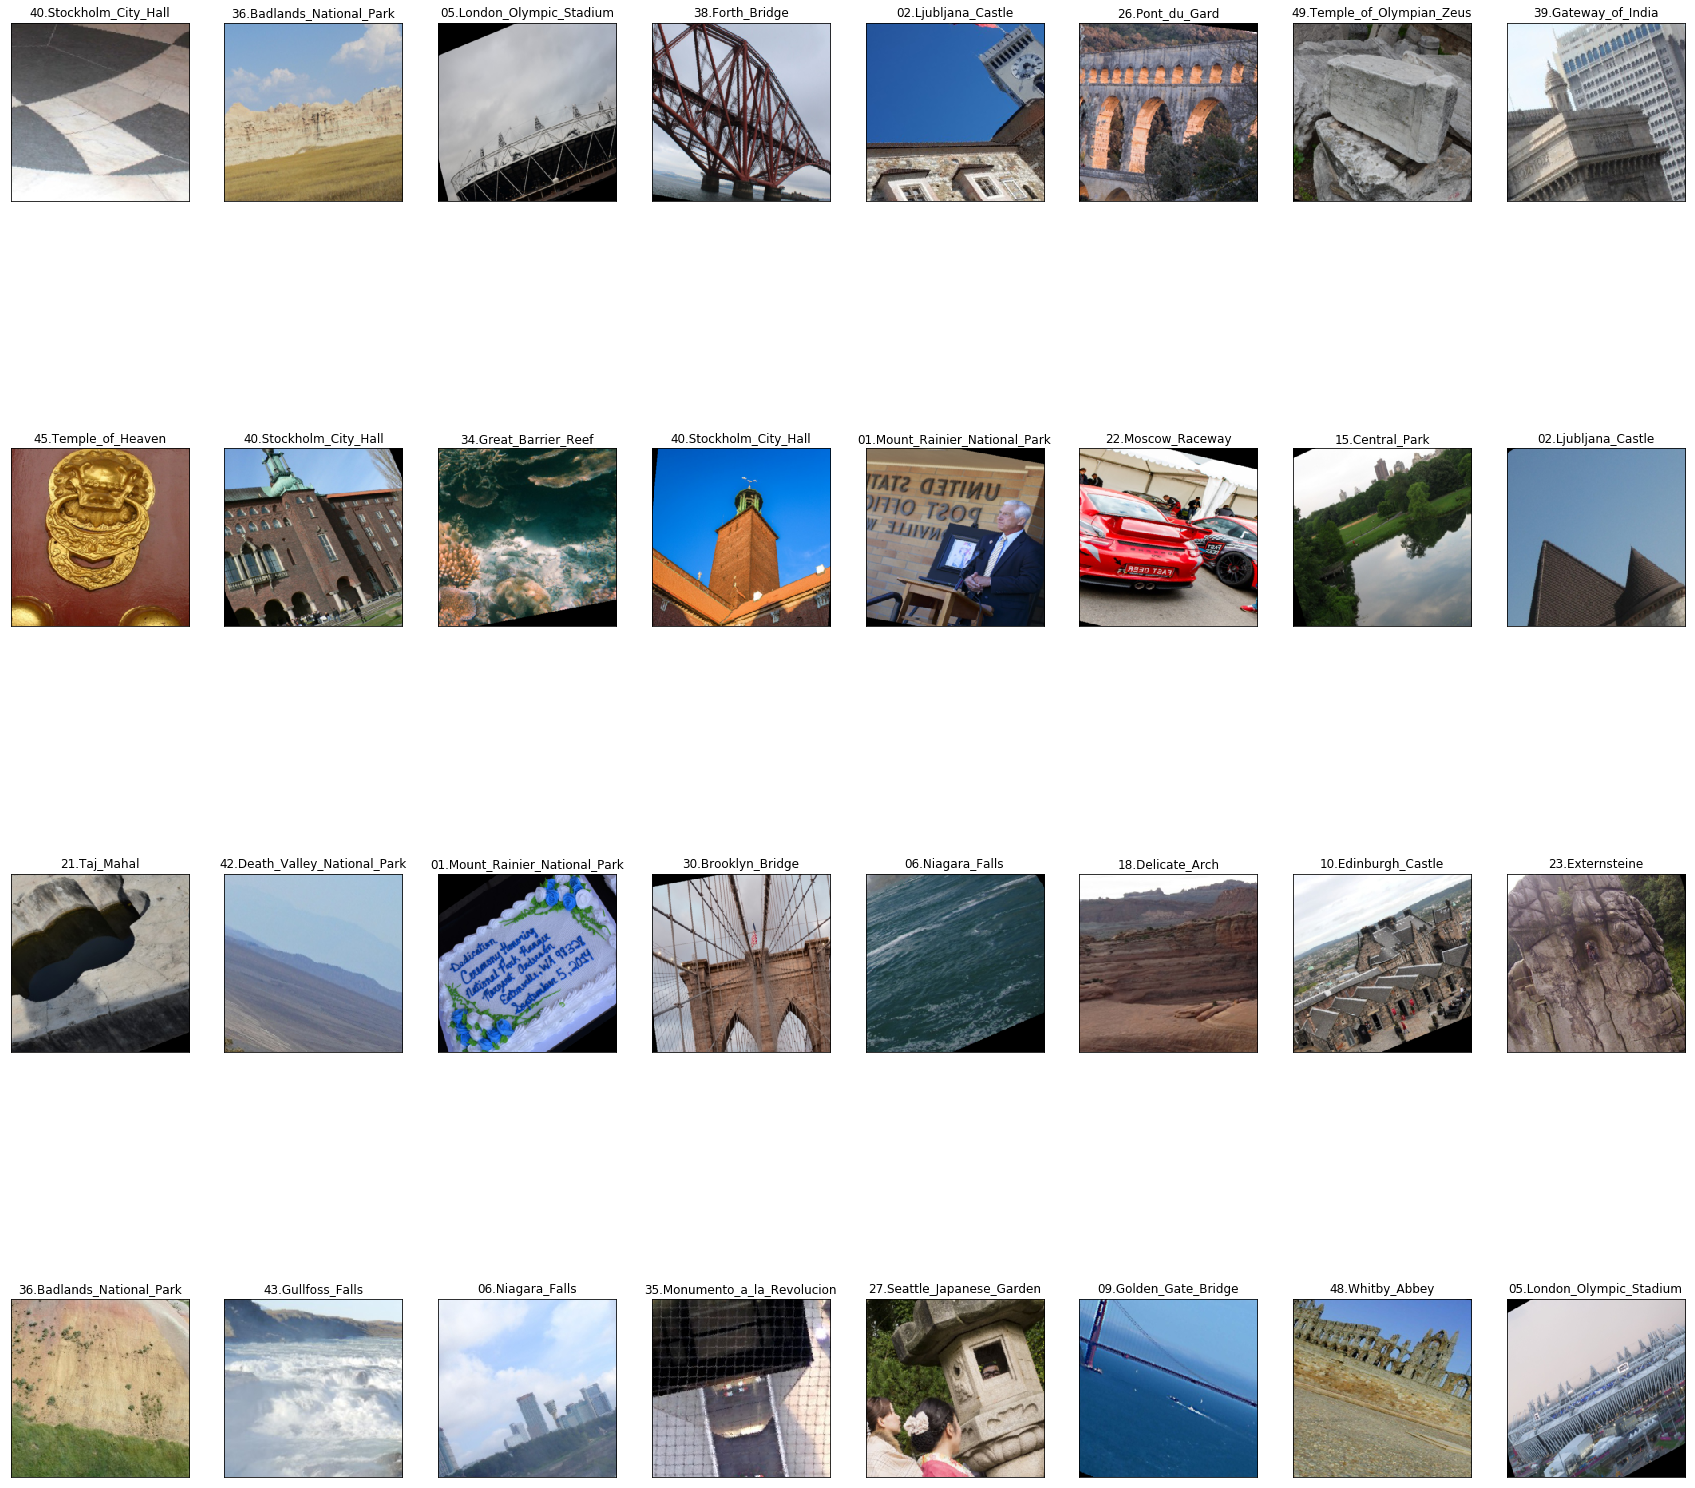

In [49]:
import matplotlib.pyplot as plt
%matplotlib inline


## TODO: visualize a batch of the train data loader
classes = train_data.classes 

def imshow(img):
    img = img / 2 + 0.5  
    plt.imshow(np.transpose(img, (1, 2, 0)))  


images, labels = next(iter(train_loader))
images = images.numpy()


fig = plt.figure(figsize=(30, 30))
for idx, image in enumerate(images):
    ax = fig.add_subplot(4, 8, idx+1, xticks=[], yticks=[])
    imshow(images[idx])
    ax.set_title(classes[labels[idx]],wrap=True)



### Initialize use_cuda variable

In [50]:
print(len(classes))
# useful variable that tells us whether we should use the GPU
use_cuda = torch.cuda.is_available()

50


### (IMPLEMENTATION) Specify Loss Function and Optimizer

Use the next code cell to specify a [loss function](http://pytorch.org/docs/stable/nn.html#loss-functions) and [optimizer](http://pytorch.org/docs/stable/optim.html).  Save the chosen loss function as `criterion_scratch`, and fill in the function `get_optimizer_scratch` below.

In [51]:
from torch import nn
## TODO: select loss function
criterion_scratch = nn.CrossEntropyLoss()

def get_optimizer_scratch(model):
    ## TODO: select and return an optimizer
    optimizer = torch.optim.Adam(model.parameters(), lr = 0.001)
    return optimizer
    
    

### (IMPLEMENTATION) Model Architecture

Create a CNN to classify images of landmarks.  Use the template in the code cell below.

In [52]:
import torch.nn as nn
import torch.nn.functional as F

# define the CNN architecture
class Net(nn.Module):
    ## TODO: choose an architecture, and complete the class
    def __init__(self):
        super(Net, self).__init__()
        
        ## Define layers of a CNN
        #defining the convolutional layers 
        self.conv1 = nn.Conv2d(3, 16 , 3, padding=1)
        self.conv2 = nn.Conv2d(16, 32 , 3, padding=1)
        self.conv3 = nn.Conv2d(32, 64 , 3, padding=1)
        #defining the maxpoolling layer
        self.pool = nn.MaxPool2d(2, 2)
        
        self.fc1 = nn.Linear(64*28*28,512)
        self.fc2 = nn.Linear(512,256)
        self.fc3 = nn.Linear(256,50)
        
        self.dropout = nn.Dropout(0.4)
        
    def forward(self, x):
        ## Define forward behavior
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        
        x = x.view(-1,64*28*28)
        x = self.dropout(x)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.fc3(x)
        
        return x

#-#-# Do NOT modify the code below this line. #-#-#

# instantiate the CNN
model_scratch = Net()

# move tensors to GPU if CUDA is available
if use_cuda:
    model_scratch.cuda()

__Question 2:__ Outline the steps you took to get to your final CNN architecture and your reasoning at each step.  

__Answer:__  
1 - first i started by initializing the convolutional layers : first conv layer was 3 in depth ,output 16 , kernel size of 3x3 and padding 1. and the second conv layer was 16 in depth, 32 output , kernel size of 3x3 and padding 1. and my last conv layer was 32 in depth and output 64 with kernel size of 3x3 and padding 1.

2 - second i initialized the pooling layer and a choose a maxpooling layer because its better in image classification and its kernel size is 2x2 and stride 2.

3 - third i initialized the fully connected layers : first layer inputs are 64x28x28 and output to 512 and second takes the output of the pervious fc as an input and its output is 256 and the last takes the output of the pervious fc as an input and the out put the number of the classes we have which is 50.

4 - last i initialized dropout layer to avoid overfitting.

that was the architecture of the CNN lets reason it first my CNN will take input of size 224x224 and depth of 3 and the out of it will be 224x224 and depth 16 and then applying maxpooling layer the size will be 112x112 the the second conv layer will take 112x112 with depth 16 and out 112x112 with depth 32 then applying the maxpooling the size will be 56x56 then the last conv layer will take input 56x56 with depth 32 and then the output will be 56x56 with depth 64 after applying the last pooling layer the size will be 28x28 with depth 64 thats why i started my fc with that number leading to the number of my classes 50 through th fcs.

### (IMPLEMENTATION) Implement the Training Algorithm

Implement your training algorithm in the code cell below.  [Save the final model parameters](http://pytorch.org/docs/master/notes/serialization.html) at the filepath stored in the variable `save_path`.

In [53]:
def train(n_epochs, loaders, model, optimizer, criterion, use_cuda, save_path):
    """returns trained model"""
    # initialize tracker for minimum validation loss
    valid_loss_min = np.Inf 
    
    for epoch in range(1, n_epochs+1):
        # initialize variables to monitor training and validation loss
        train_loss = 0.0
        valid_loss = 0.0
        
        ###################
        # train the model #
        ###################
        # set the module to training mode
        model.train()
        for batch_idx, (data, target) in enumerate(loaders['train']):
            # move to GPU
            if use_cuda:
                data, target = data.cuda(), target.cuda() 

            ## TODO: find the loss and update the model parameters accordingly
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output,target)
            loss.backward()
            optimizer.step()
            
            ## record the average training loss, using something like
            train_loss = train_loss + ((1 / (batch_idx + 1)) * (loss.data.item() - train_loss))
            
            
            
            

        ######################    
        # validate the model #
        ######################
        # set the model to evaluation mode
        model.eval()
        for batch_idx, (data, target) in enumerate(loaders['valid']):
            # move to GPU
            if use_cuda:
                data, target = data.cuda(), target.cuda()    

            ## TODO: update average validation loss 
            output = model(data)
            loss = criterion_scratch(output,target)
            
            valid_loss = valid_loss + ((1 / (batch_idx + 1)) * (loss.data.item() - valid_loss))
            
            

        # print training/validation statistics 
        print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
            epoch, 
            train_loss,
            valid_loss
            ))

        ## TODO: if the validation loss has decreased, save the model at the filepath stored in save_path
        if valid_loss <= valid_loss_min:
            print('Validation decreased from ({:.6f} to {:.6f}) Saving the model.'.format(valid_loss_min,valid_loss))
            torch.save(model.state_dict(), save_path )
            valid_loss_min = valid_loss
        
        
    return model

### (IMPLEMENTATION) Experiment with the Weight Initialization

Use the code cell below to define a custom weight initialization, and then train with your weight initialization for a few epochs. Make sure that neither the training loss nor validation loss is `nan`.

Later on, you will be able to see how this compares to training with PyTorch's default weight initialization.

In [57]:
def custom_weight_init(m):
    ## TODO: implement a weight initialization strategy
    classname = m.__class__.__name__
    if classname.find('Linear') != -1:
        n = m.in_features
        y = 1/(np.sqrt(n))
        m.weight.data.normal_(0,y)
        m.bias.data.fill_(0)

#-#-# Do NOT modify the code below this line. #-#-#
    
model_scratch.apply(custom_weight_init)
model_scratch = train(20, loaders_scratch, model_scratch, get_optimizer_scratch(model_scratch),
                      criterion_scratch, use_cuda, 'ignore.pt')

Epoch: 1 	Training Loss: 3.924761 	Validation Loss: 3.901811
Validation decreased from (inf to 3.901811) Saving the model.
Epoch: 2 	Training Loss: 3.879920 	Validation Loss: 3.861487
Validation decreased from (3.901811 to 3.861487) Saving the model.
Epoch: 3 	Training Loss: 3.848208 	Validation Loss: 3.797571
Validation decreased from (3.861487 to 3.797571) Saving the model.
Epoch: 4 	Training Loss: 3.779243 	Validation Loss: 3.740943
Validation decreased from (3.797571 to 3.740943) Saving the model.
Epoch: 5 	Training Loss: 3.743214 	Validation Loss: 3.709318
Validation decreased from (3.740943 to 3.709318) Saving the model.
Epoch: 6 	Training Loss: 3.679854 	Validation Loss: 3.646816
Validation decreased from (3.709318 to 3.646816) Saving the model.
Epoch: 7 	Training Loss: 3.667469 	Validation Loss: 3.621438
Validation decreased from (3.646816 to 3.621438) Saving the model.
Epoch: 8 	Training Loss: 3.627987 	Validation Loss: 3.604732
Validation decreased from (3.621438 to 3.604732)

### (IMPLEMENTATION) Train and Validate the Model

Run the next code cell to train your model.

In [12]:
## TODO: you may change the number of epochs if you'd like,
## but changing it is not required
num_epochs = 30

#-#-# Do NOT modify the code below this line. #-#-#

# function to re-initialize a model with pytorch's default weight initialization
def default_weight_init(m):
    reset_parameters = getattr(m, 'reset_parameters', None)
    if callable(reset_parameters):
        m.reset_parameters()

# reset the model parameters
model_scratch.apply(default_weight_init)

# train the model
model_scratch = train(num_epochs, loaders_scratch, model_scratch, get_optimizer_scratch(model_scratch), 
                      criterion_scratch, use_cuda, 'model_scratch.pt')

Epoch: 1 	Training Loss: 3.894008 	Validation Loss: 3.809580
Validation decreased from (inf to 3.809580) Saving the model.
Epoch: 2 	Training Loss: 3.806479 	Validation Loss: 3.763415
Validation decreased from (3.809580 to 3.763415) Saving the model.
Epoch: 3 	Training Loss: 3.738203 	Validation Loss: 3.667042
Validation decreased from (3.763415 to 3.667042) Saving the model.
Epoch: 4 	Training Loss: 3.665038 	Validation Loss: 3.611295
Validation decreased from (3.667042 to 3.611295) Saving the model.
Epoch: 5 	Training Loss: 3.623709 	Validation Loss: 3.555355
Validation decreased from (3.611295 to 3.555355) Saving the model.
Epoch: 6 	Training Loss: 3.534584 	Validation Loss: 3.463688
Validation decreased from (3.555355 to 3.463688) Saving the model.
Epoch: 7 	Training Loss: 3.467975 	Validation Loss: 3.414739
Validation decreased from (3.463688 to 3.414739) Saving the model.
Epoch: 8 	Training Loss: 3.425346 	Validation Loss: 3.366399
Validation decreased from (3.414739 to 3.366399)

### (IMPLEMENTATION) Test the Model

Run the code cell below to try out your model on the test dataset of landmark images. Run the code cell below to calculate and print the test loss and accuracy.  Ensure that your test accuracy is greater than 20%.

In [13]:
def test(loaders, model, criterion, use_cuda):

    # monitor test loss and accuracy
    test_loss = 0.
    correct = 0.
    total = 0.

    # set the module to evaluation mode
    model.eval()

    for batch_idx, (data, target) in enumerate(loaders['test']):
        # move to GPU
        if use_cuda:
            data, target = data.cuda(), target.cuda()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the loss
        loss = criterion(output, target)
        # update average test loss 
        test_loss = test_loss + ((1 / (batch_idx + 1)) * (loss.data.item() - test_loss))
        # convert output probabilities to predicted class
        pred = output.data.max(1, keepdim=True)[1]
        # compare predictions to true label
        correct += np.sum(np.squeeze(pred.eq(target.data.view_as(pred))).cpu().numpy())
        total += data.size(0)
            
    print('Test Loss: {:.6f}\n'.format(test_loss))

    print('\nTest Accuracy: %2d%% (%2d/%2d)' % (
        100. * correct / total, correct, total))

# load the model that got the best validation accuracy
model_scratch.load_state_dict(torch.load('model_scratch.pt'))
test(loaders_scratch, model_scratch, criterion_scratch, use_cuda)

Test Loss: 2.567671


Test Accuracy: 33% (419/1250)


---
<a id='step2'></a>
## Step 2: Create a CNN to Classify Landmarks (using Transfer Learning)

You will now use transfer learning to create a CNN that can identify landmarks from images.  Your CNN must attain at least 60% accuracy on the test set.

### (IMPLEMENTATION) Specify Data Loaders for the Landmark Dataset

Use the code cell below to create three separate [data loaders](http://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader): one for training data, one for validation data, and one for test data. Randomly split the images located at `landmark_images/train` to create the train and validation data loaders, and use the images located at `landmark_images/test` to create the test data loader.

All three of your data loaders should be accessible via a dictionary named `loaders_transfer`. Your train data loader should be at `loaders_transfer['train']`, your validation data loader should be at `loaders_transfer['valid']`, and your test data loader should be at `loaders_transfer['test']`.

If you like, **you are welcome to use the same data loaders from the previous step**, when you created a CNN from scratch.

In [7]:
### TODO: Write data loaders for training, validation, and test sets
## Specify appropriate transforms, and batch_sizes

loaders_transfer = {'train': train_loader , 'valid': validation_loader , 'test': test_loader }


### (IMPLEMENTATION) Specify Loss Function and Optimizer

Use the next code cell to specify a [loss function](http://pytorch.org/docs/stable/nn.html#loss-functions) and [optimizer](http://pytorch.org/docs/stable/optim.html).  Save the chosen loss function as `criterion_transfer`, and fill in the function `get_optimizer_transfer` below.

In [37]:
## TODO: select loss function
criterion_transfer = nn.NLLLoss()


def get_optimizer_transfer(model):
    ## TODO: select and return optimizer
    optimizer = torch.optim.Adam(model.fc.parameters(), lr = 0.001 )
    return optimizer
    
    

### (IMPLEMENTATION) Model Architecture

Use transfer learning to create a CNN to classify images of landmarks.  Use the code cell below, and save your initialized model as the variable `model_transfer`.

In [38]:
from torchvision import models
## TODO: Specify model architecture
dir(models)
model_transfer = models.resnet50(pretrained = True )
for param in model_transfer.parameters():
    param.requires_grad = False

model_transfer.fc = nn.Sequential(nn.Linear(2048,512),
                                  nn.ReLU(),
                                  nn.Dropout(0.5),
                                  nn.Linear(512,50),
                                  nn.LogSoftmax(dim=1))

print(model_transfer)






#-#-# Do NOT modify the code below this line. #-#-#

if use_cuda:
    model_transfer = model_transfer.cuda()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=F

__Question 3:__ Outline the steps you took to get to your final CNN architecture and your reasoning at each step.  Describe why you think the architecture is suitable for the current problem.

__Answer:__ 

1 - first step i searched for the best pretrained image classifier model and found some good models but i chose resnet-50 because its size is small and its accuracy is quite high so i used it.

2 -  applied it and freezed its parameters then changed its fc to be good for my project so it has 50 output due to our 50 class.

3 -  i think its sutiable because this is the best model for image classification with some adds from me it will be perfect for our problem.

### (IMPLEMENTATION) Train and Validate the Model

Train and validate your model in the code cell below.  [Save the final model parameters](http://pytorch.org/docs/master/notes/serialization.html) at filepath `'model_transfer.pt'`.

In [39]:
# TODO: train the model and save the best model parameters at filepath 'model_transfer.pt'

train(20, loaders_transfer, model_transfer, get_optimizer_transfer(model_transfer),
                      criterion_transfer, use_cuda, 'model_transfer.pt')

#-#-# Do NOT modify the code below this line. #-#-#

# load the model that got the best validation accuracy
model_transfer.load_state_dict(torch.load('model_transfer.pt'))

Epoch: 1 	Training Loss: 3.455863 	Validation Loss: 2.585810
Validation decreased from (inf to 2.585810) Saving the model.
Epoch: 2 	Training Loss: 2.569842 	Validation Loss: 2.042339
Validation decreased from (2.585810 to 2.042339) Saving the model.
Epoch: 3 	Training Loss: 2.220436 	Validation Loss: 1.824096
Validation decreased from (2.042339 to 1.824096) Saving the model.
Epoch: 4 	Training Loss: 2.005335 	Validation Loss: 1.658634
Validation decreased from (1.824096 to 1.658634) Saving the model.
Epoch: 5 	Training Loss: 1.922422 	Validation Loss: 1.687111
Epoch: 6 	Training Loss: 1.832266 	Validation Loss: 1.532106
Validation decreased from (1.658634 to 1.532106) Saving the model.
Epoch: 7 	Training Loss: 1.772419 	Validation Loss: 1.536272
Epoch: 8 	Training Loss: 1.743777 	Validation Loss: 1.435668
Validation decreased from (1.532106 to 1.435668) Saving the model.
Epoch: 9 	Training Loss: 1.670385 	Validation Loss: 1.442915
Epoch: 10 	Training Loss: 1.673892 	Validation Loss: 1

### (IMPLEMENTATION) Test the Model

Try out your model on the test dataset of landmark images. Use the code cell below to calculate and print the test loss and accuracy.  Ensure that your test accuracy is greater than 60%.

In [40]:
def test(loaders, model, criterion, use_cuda):

    # monitor test loss and accuracy
    test_loss = 0.
    correct = 0.
    total = 0.

    # set the module to evaluation mode
    model.eval()

    for batch_idx, (data, target) in enumerate(loaders['test']):
        # move to GPU
        if use_cuda:
            data, target = data.cuda(), target.cuda()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the loss
        loss = criterion(output, target)
        # update average test loss 
        test_loss = test_loss + ((1 / (batch_idx + 1)) * (loss.data.item() - test_loss))
        # convert output probabilities to predicted class
        pred = output.data.max(1, keepdim=True)[1]
        # compare predictions to true label
        correct += np.sum(np.squeeze(pred.eq(target.data.view_as(pred))).cpu().numpy())
        total += data.size(0)
            
    print('Test Loss: {:.6f}\n'.format(test_loss))

    print('\nTest Accuracy: %2d%% (%2d/%2d)' % (
        100. * correct / total, correct, total))

# load the model that got the best validation accuracy
model_transfer.load_state_dict(torch.load('model_transfer.pt'))

test(loaders_transfer, model_transfer, criterion_transfer, use_cuda)

Test Loss: 0.983252


Test Accuracy: 74% (927/1250)


---
<a id='step3'></a>
## Step 3: Write Your Landmark Prediction Algorithm

Great job creating your CNN models! Now that you have put in all the hard work of creating accurate classifiers, let's define some functions to make it easy for others to use your classifiers.

### (IMPLEMENTATION) Write Your Algorithm, Part 1

Implement the function `predict_landmarks`, which accepts a file path to an image and an integer k, and then predicts the **top k most likely landmarks**. You are **required** to use your transfer learned CNN from Step 2 to predict the landmarks.

An example of the expected behavior of `predict_landmarks`:
```
>>> predicted_landmarks = predict_landmarks('example_image.jpg', 3)
>>> print(predicted_landmarks)
['Golden Gate Bridge', 'Brooklyn Bridge', 'Sydney Harbour Bridge']
```

In [41]:
import cv2
from PIL import Image

## the class names can be accessed at the `classes` attribute
## of your dataset object (e.g., `train_dataset.classes`)

def predict_landmarks(img_path, k):
    ## TODO: return the names of the top k landmarks predicted by the transfer learned CNN
    img = Image.open(img_path).convert('RGB')
    transform = transforms.Compose([transforms.Resize(224),
                                    transforms.CenterCrop(224),
                                    transforms.ToTensor(),
                                    transforms.Normalize([0.5,0.5,0.5],
                                                        [0.5,0.5,0.5])])
    imgT = transform(img)
    imageB = torch.unsqueeze(imgT,0)
    model_transfer.eval()
    if use_cuda:
        imageB = imageB.cuda()
    with torch.no_grad():
        output = model_transfer(imageB)
    _, index = torch.topk(output.squeeze(0),k)
    
    classes_M = [x[3:].replace('_',' ') for x in classes]
    return [classes_M[i] for i in index]
    
    


# test on a sample image
predict_landmarks('images/test/16.Eiffel_Tower/3828627c8730f160.jpg', 5)

['Sydney Harbour Bridge',
 'Eiffel Tower',
 'Sydney Opera House',
 'Brooklyn Bridge',
 'Forth Bridge']

### (IMPLEMENTATION) Write Your Algorithm, Part 2

In the code cell below, implement the function `suggest_locations`, which accepts a file path to an image as input, and then displays the image and the **top 3 most likely landmarks** as predicted by `predict_landmarks`.

Some sample output for `suggest_locations` is provided below, but feel free to design your own user experience!
![](images/sample_landmark_output.png)

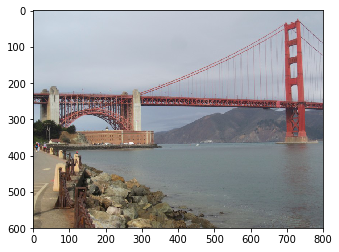

Is this picture of the... "Golden Gate Bridge", "Forth Bridge", or "Sydney Harbour Bridge"


In [42]:
def suggest_locations(img_path):
    # get landmark predictions
    predicted_landmarks = predict_landmarks(img_path, 3)
    
    ## TODO: display image and display landmark predictions
    img = Image.open(img_path)
    plt.imshow(img)
    plt.show()
    print ('Is this picture of the... "{}", "{}", or "{}"'.format(predicted_landmarks[0], predicted_landmarks[1], predicted_landmarks[2]))
# test on a sample image
suggest_locations('images/test/09.Golden_Gate_Bridge/190f3bae17c32c37.jpg')

### (IMPLEMENTATION) Test Your Algorithm

Test your algorithm by running the `suggest_locations` function on at least four images on your computer. Feel free to use any images you like.

__Question 4:__ Is the output better than you expected :) ?  Or worse :( ?  Provide at least three possible points of improvement for your algorithm.

__Answer:__ 
it was good not better or worse but needed more improvments
(Three possible points for improvement)
1 - more data so it get better data such as classes and more data in each class so when the model train on different view of the landmark when he sees it with any angle it will be esasy to predict correct.

2- the model used must be more accuracy instead of 74 i think it should be 80 at least.

3 - transforms also play a big role so different transforms applies on the image will help to predict easily

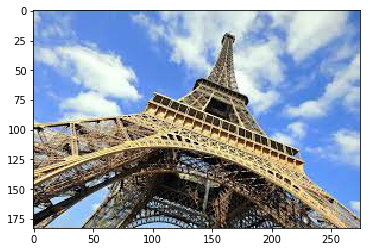

Is this picture of the... "Eiffel Tower", "Vienna City Hall", or "Terminal Tower"


In [43]:
## TODO: Execute the `suggest_locations` function on
## at least 4 images on your computer.
## Feel free to use as many code cells as needed.
suggest_locations('test_images/effil')

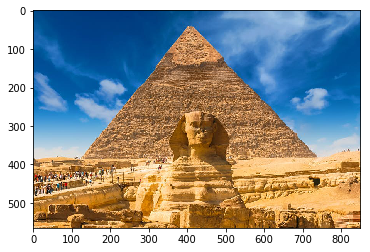

Is this picture of the... "Whitby Abbey", "Kantanagar Temple", or "Mount Rushmore National Memorial"


In [44]:
suggest_locations('test_images/pyramids.jpg')

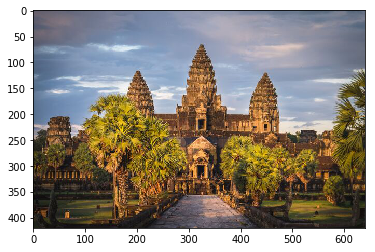

Is this picture of the... "Terminal Tower", "Vienna City Hall", or "Eiffel Tower"


In [45]:
suggest_locations('test_images/pic1')

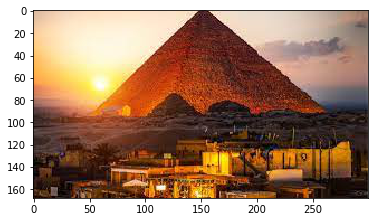

Is this picture of the... "Grand Canyon", "Delicate Arch", or "Death Valley National Park"


In [46]:
suggest_locations('test_images/pic2')

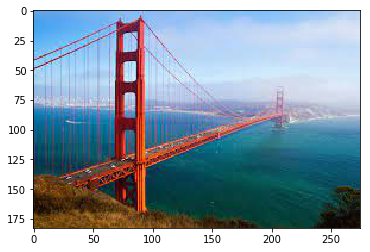

Is this picture of the... "Golden Gate Bridge", "Forth Bridge", or "Brooklyn Bridge"


In [47]:
suggest_locations('test_images/landmark')

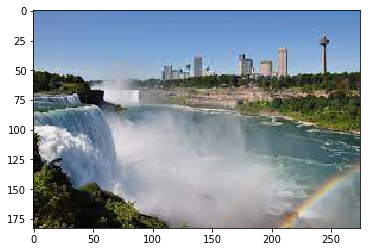

Is this picture of the... "Niagara Falls", "Yellowstone National Park", or "Banff National Park"


In [54]:
suggest_locations('test_images/niagara_falls.jfif')

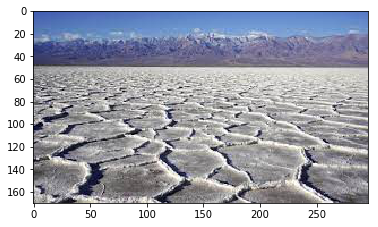

Is this picture of the... "Seattle Japanese Garden", "Great Wall of China", or "Death Valley National Park"


In [55]:
suggest_locations('test_images/death.jfif')

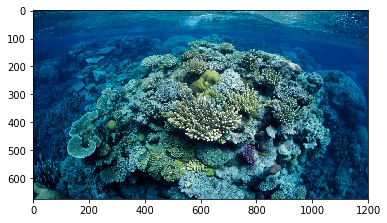

Is this picture of the... "Great Barrier Reef", "Seattle Japanese Garden", or "Central Park"


In [56]:
suggest_locations('test_images/great-barrier-reef-file.jpg')